In [70]:
import numpy as np
import scipy.constants as const
import uncertainties as unc
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat,unumpy  #for uncertainty object creation/manipulation
from uncertainties.umath import *  #for math on uncertainty objects
%matplotlib inline

In [71]:
from lmfit.models import QuadraticModel, LorentzianModel

# Helper Functions used. 

In [72]:
#to calculate current as a function of time   
def find_current(time, period, current_min, current_max):
    mca_sweep_time = 20.48
    seperation = period/2 
    amplitude = current_max - current_min
    if time < seperation:
        return current_min + amplitude*(time-0)/seperation
    else:
        return current_max - amplitude*(time-seperation)/seperation
    
#to find the life time if we know the ΔB_half
def find_lifetime(ΔB_half):
    g_factor = 3/2
    μB = const.e*const.hbar/(2*const.m_e)
    f = 2 * g_factor * μB/const.hbar * np.abs(ΔB_half)
    τ = 1/f
    return τ

#to calculate the magnetic field as a function of current, we use the ratio 14.3 Gauss/Ampere
def find_B_field(current, coil_ratio=14.3/10000):
    return current*coil_ratio

#to find the corresponding time of a given channel 
def find_time(channel, period, channel_num=1024):
    return channel*20/1000

Here is a function that builds up a dataframe given our data, which includes the calculations of time, current, magnetic field.  

In [96]:
def processing(f, period, current_min, current_max, channel_num):
    column_name=['channel', 'count']

    data = pd.read_csv(f, header=None,
                        delimiter="	",
                        skipinitialspace=True,
                        names=column_name
                        )
    coil_ratio=14.3/10000
    
    period = period # s
    current_min = current_min # A
    current_max = current_max # A
    channel_num= channel_num
    dwell_time = period/(channel_num-1)

    data['time'] = data['channel']*dwell_time
    data['current'] = [find_current(t, period, current_min, current_max) for t in data['time']]
    data['B field'] = data['current']*coil_ratio # 14.3 Gauss/A to Tesla, 10000 Gauss = 1 Tesla
    return data

Here is my function to visualize the dataframe that I've created. I plot 3 plots: one for time versus current; channel number versus magnetic field; and lastly channel number versus count, which is what we got from the MCA directly. 

In [74]:
import seaborn as sns

def myplot(data):
    sns.set_theme()
    fig,axes = plt.subplots(3,1)                    # One window
    fig.set_size_inches(8,20)                      # (width,height)
    current = [i.n for i in data['current']] 
    B = [i.n for i in data['B field']] #unc object nomial value
    
    #time versus current
    axes[0].plot(data['time'], current)
    axes[0].set_xlabel("time")
    axes[0].set_ylabel("current")
    axes[0].set_title("function generator's current")

    #channel versus Bfield 
    axes[1].plot(data['channel'], B)
    axes[1].set_xlabel("channel")
    axes[1].set_ylabel("B field")
    axes[1].set_title("corresponding B field")

    #channel versus counts
    axes[2].plot(data['channel'], data['count'])
    axes[2].set_xlabel("channel")
    axes[2].set_ylabel("counts")
    axes[2].set_title("photon counts detected")

## Make the model

The model fit will consist of two Lorentzian peaks and a quadratic background.

The background fuction has the form
$$f(x;a,b,c) = ax^2 + bx + c\;.$$

The Lorentzian lineshape has the form
$$f(x;A,\mu,\sigma) = \frac{A}{\pi}\left[\frac{\sigma}{(x-\mu)^2 + \sigma^2}\right]\;.$$ 

Note that the height of the peak at the center ($x=\mu$) is equal to $\frac{A}{\pi\sigma}$ and that the full-width at half-maximum is $2\sigma$.

Thus, to estimate the amplitude $A$, estimate the height $h$ and half-width at half-maximum $\sigma$ from a graph, and calculate $A = h\pi\sigma$.

## What we need from that model
We are looking for the half-width $\sigma$, as it is needed from this equation to calculate the half life. 
\begin{equation}
    f = 2 g_j \frac {\mu_B} {h} \Delta B_{\frac {1}{2}} \\
    \tau = \frac 1 f
\end{equation}

In [75]:
def make_model(data, period, current_min, current_max):
    #no background, two lorentzian models
    model = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')
    params = model.make_params()
    
    #print('parameter names: {}'.format(model.param_names))
    params['p1_amplitude'].set(value=-4000.0*15*np.pi, vary=True)
    params['p1_center'].set(value=250., vary=True)
    params['p1_sigma'].set(value=15, vary=True)

    params['p2_amplitude'].set(value=-4000.0*15*np.pi, vary=True)
    params['p2_center'].set(value=750., vary=True)
    params['p2_sigma'].set(value=15, vary=True)

    params['a'].set(value = 0, vary=False)
    params['b'].set(value = 0, vary=False)
    params['c'].set(value = 10000.0, vary=True)

    model_fit = model.fit(data['count'], params, x=data['channel'], weights=1/np.sqrt(data['count']))

    #print(model_fit.fit_report(show_correl=False))
    myfig = plt.figure(figsize=(10,10))
    model_fit.plot(fig=myfig);
    
    plt.minorticks_on()
    plt.grid(which="major", linestyle='-', linewidth=0.5, c='blue')
    plt.grid(which="minor", linestyle=':', linewidth=0.5, c='black')
    

    half_width = model_fit.params['p1_center'].value-model_fit.params['p1_sigma'].value
    std_half_width = np.abs(model_fit.params['p1_center'].stderr-model_fit.params['p1_sigma'].stderr)
    unc_1 = unc.ufloat(model_fit.params['p1_sigma'].value, model_fit.params['p1_sigma'].stderr)
    
    u_channel = unc.ufloat(half_width,std_half_width)
    
    t = find_time(u_channel, period)
    i = find_current(t, period, current_min, current_max)
    ΔB = find_B_field(i)
    τ_1 = find_lifetime(ΔB)

    print("τ =", τ_1, "s")
    
    half_width = model_fit.params['p2_center'].value-model_fit.params['p2_sigma'].value
    std_half_width = np.abs(model_fit.params['p2_center'].stderr-model_fit.params['p2_sigma'].stderr)
    u_channel = unc.ufloat(half_width,std_half_width)
    unc_2 = unc.ufloat(model_fit.params['p2_sigma'].value, model_fit.params['p2_sigma'].stderr)

    t = find_time(u_channel, period)
    i = find_current(t, period, current_min, current_max)
    ΔB = find_B_field(i)
    τ_2 = find_lifetime(ΔB)

    print("τ =", τ_2, "s")
    
    return τ_1, τ_2, model_fit.params

# We processed 3 datasets (polarization angle: 0&deg;, 180&deg;, and 180&deg; in presence of earth magnetic field)


## 0&deg; here

τ = (1.84+/-0.04)e-07 s
τ = (9.43+/-0.10)e-08 s
Name             Value   Stderr     Vary
a                    0        0    False
b                    0        0    False
c             1.357e+05    39.06     True
p1_amplitude  -5.051e+06 1.873e+04     True
p1_center          269  0.07609     True
p1_fwhm          55.49    0.248    False
p1_height     -5.794e+04    147.3    False
p1_sigma         27.75    0.124     True
p2_amplitude  -4.951e+06 1.846e+04     True
p2_center        783.1  0.07561     True
p2_fwhm          54.54   0.2457    False
p2_height     -5.78e+04    148.8    False
p2_sigma         27.27   0.1229     True


1.3916293376453822e-07+/-1.4507143688694636e-09

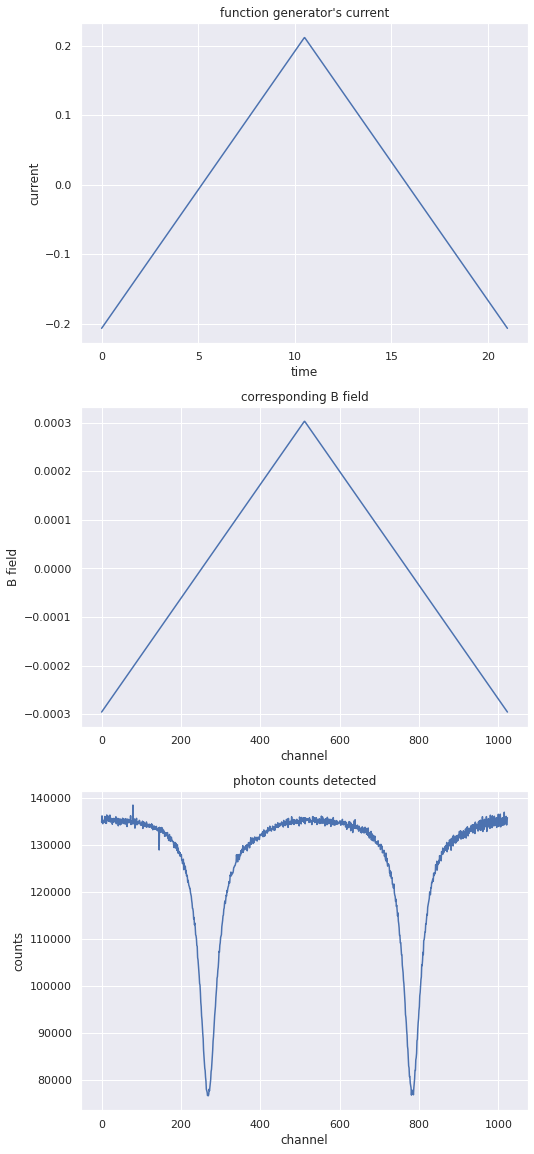

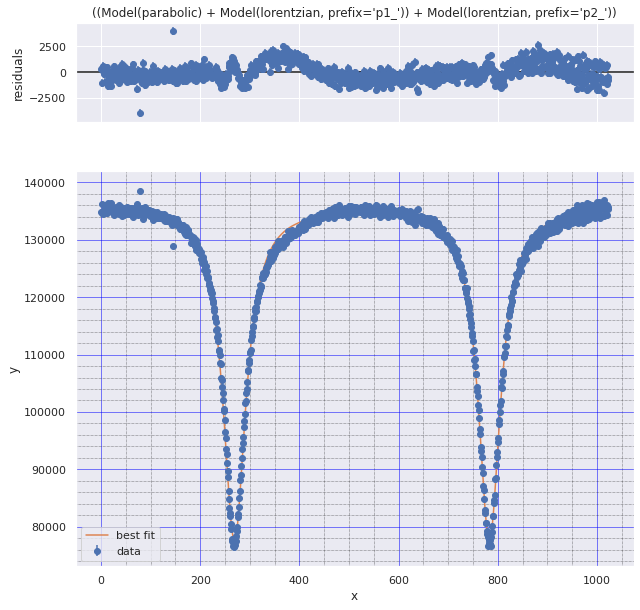

In [76]:
data_file = './Data/hanle_0'
period = 21.0084
channel_num= 1024

current_min = np.array([-0.20633,-0.20618,-0.20681,-0.20741,-0.20691])
current_max = np.array([0.21174,0.21158,0.21217,0.21271,0.21197])

current_min = unc.ufloat(current_min.mean(),current_min.std())
current_max = unc.ufloat(current_max.mean(),current_max.std())

column_name=['channel', 'count']
data = processing(data_file,
                    period = period,
                    current_min = current_min,
                    current_max = current_max,
                    channel_num= channel_num)

myplot(data)
τ1, τ2, params = make_model(data, period, current_min, current_max)
τ_mean = (τ1+τ2)/2
params.pretty_print(columns=['value','stderr','vary'])
τ_mean

## 180&deg; here

τ = (2.7+/-0.5)e-07 s
τ = (1.74+/-0.19)e-07 s
Name             Value   Stderr     Vary
a                    0        0    False
b                    0        0    False
c             5.703e+04    22.15     True
p1_amplitude  -2.803e+06 1.011e+04     True
p1_center        271.6  0.06803     True
p1_fwhm          52.77   0.2246    False
p1_height     -3.382e+04    76.92    False
p1_sigma         26.38   0.1123     True
p2_amplitude  -2.757e+06     9965     True
p2_center        799.8  0.06754     True
p2_fwhm          51.95   0.2222    False
p2_height     -3.379e+04    77.67    False
p2_sigma         25.98   0.1111     True


2.2324023798921152e-07+/-1.696411463973414e-08

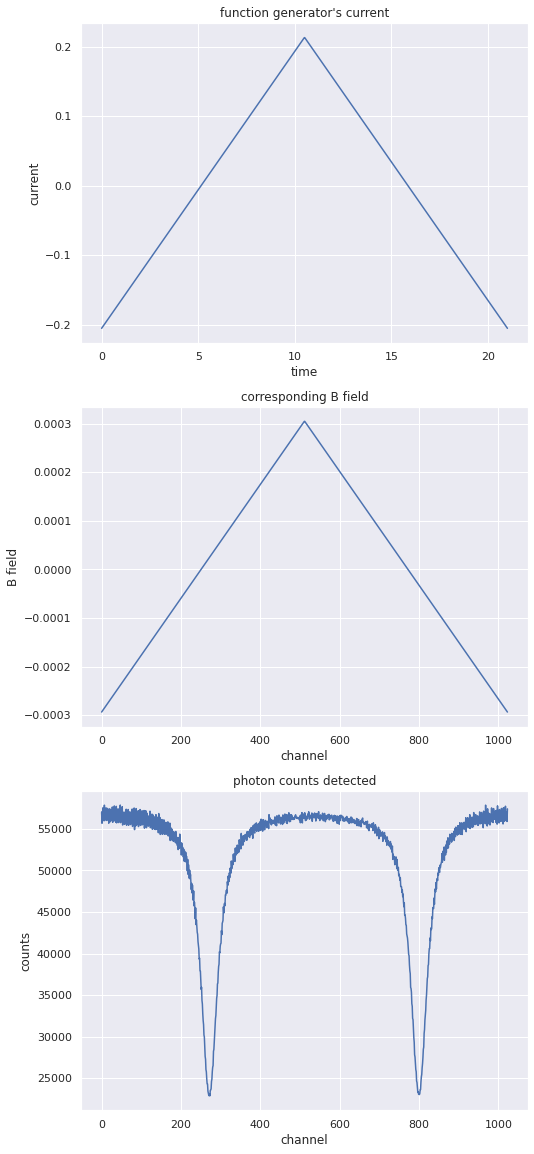

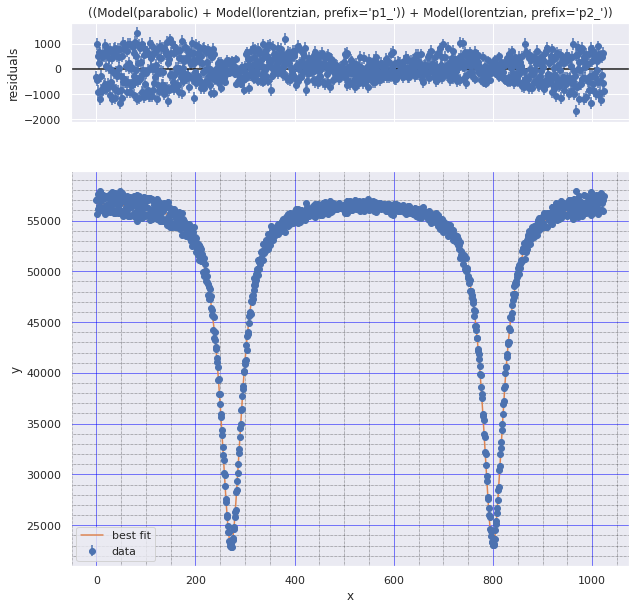

In [77]:
data_file = './Data/hanle_180'
period = 21.0084
channel_num= 1024

current_min = np.array([-0.19819,-0.20710,-0.20710,-0.20710,-0.20694])
current_max = np.array([0.21369,0.21367,0.21396,0.21316,0.21316])

current_min = unc.ufloat(current_min.mean(),current_min.std())
current_max = unc.ufloat(current_max.mean(),current_max.std())

column_name=['channel', 'count']
data = processing(data_file,
                    period = period,
                    current_min = current_min,
                    current_max = current_max,
                    channel_num= channel_num)

myplot(data)
τ1, τ2, params = make_model(data, period, current_min, current_max)
τ_mean = (τ1+τ2)/2
params.pretty_print(columns=['value','stderr','vary'])
τ_mean

# 180&deg; in the presence of earth magnetic field here

τ = (1.46+/-0.16)e-07 s
τ = (2.4+/-0.4)e-07 s
Name             Value   Stderr     Vary
a                    0        0    False
b                    0        0    False
c             9.922e+04    80.43     True
p1_amplitude  -5.065e+06 3.816e+04     True
p1_center        263.6   0.1527     True
p1_fwhm          57.76   0.5146    False
p1_height     -5.582e+04      269    False
p1_sigma         28.88   0.2573     True
p2_amplitude  -5.043e+06 3.779e+04     True
p2_center          808   0.1517     True
p2_fwhm           57.4   0.5095    False
p2_height     -5.593e+04    269.9    False
p2_sigma          28.7   0.2548     True


1.94128858539769e-07+/-1.1187051486450587e-08

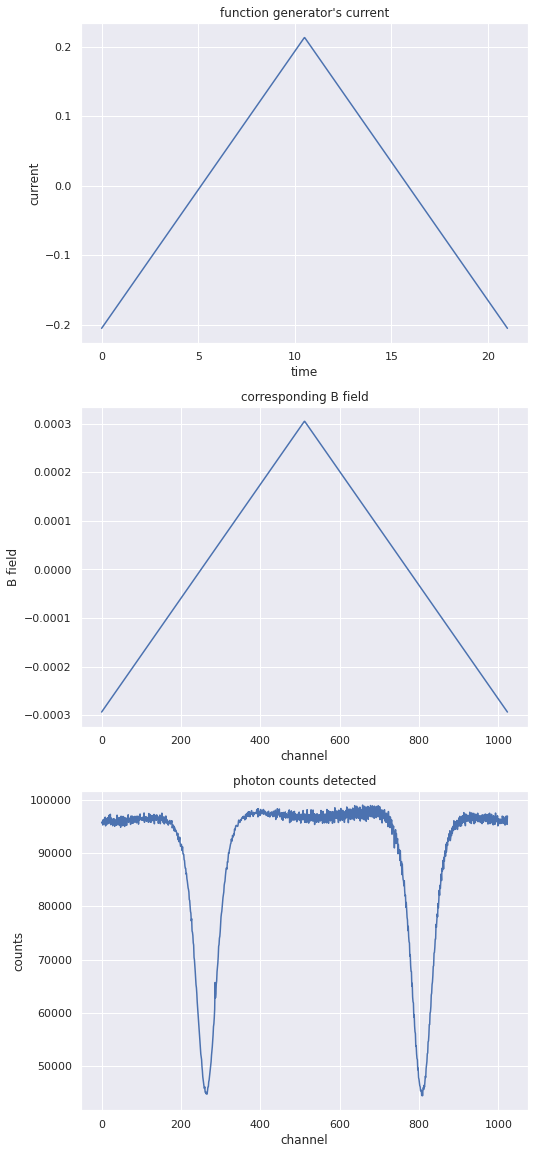

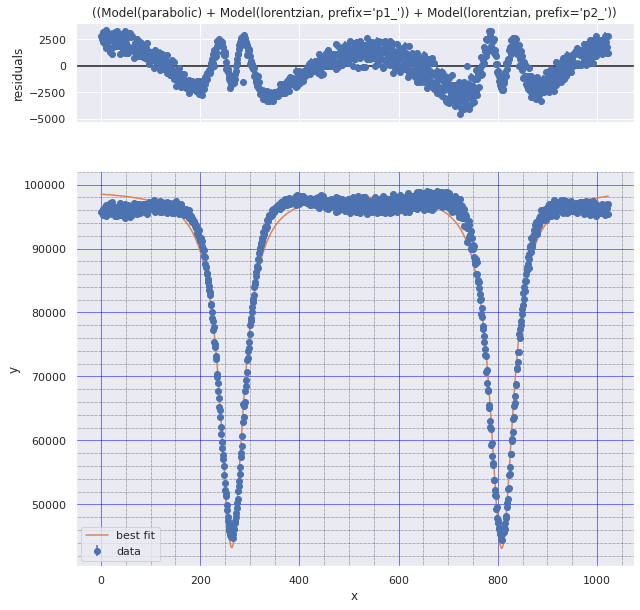

In [78]:
data_file = './Data/earth_Bfield'
period = 21.0084
channel_num= 1024

current_min = np.array([-0.19819,-0.20710,-0.20710,-0.20710,-0.20694])
current_max = np.array([0.21369,0.21367,0.21396,0.21316,0.21316])

current_min = unc.ufloat(current_min.mean(),current_min.std())
current_max = unc.ufloat(current_max.mean(),current_max.std())

column_name=['channel', 'count']
data = processing(data_file,
                    period = period,
                    current_min = current_min,
                    current_max = current_max,
                    channel_num= channel_num)

myplot(data)
τ1, τ2, params= make_model(data, period, current_min, current_max)
τ_mean = (τ1+τ2)/2
params.pretty_print(columns=['value','stderr','vary'])
τ_mean

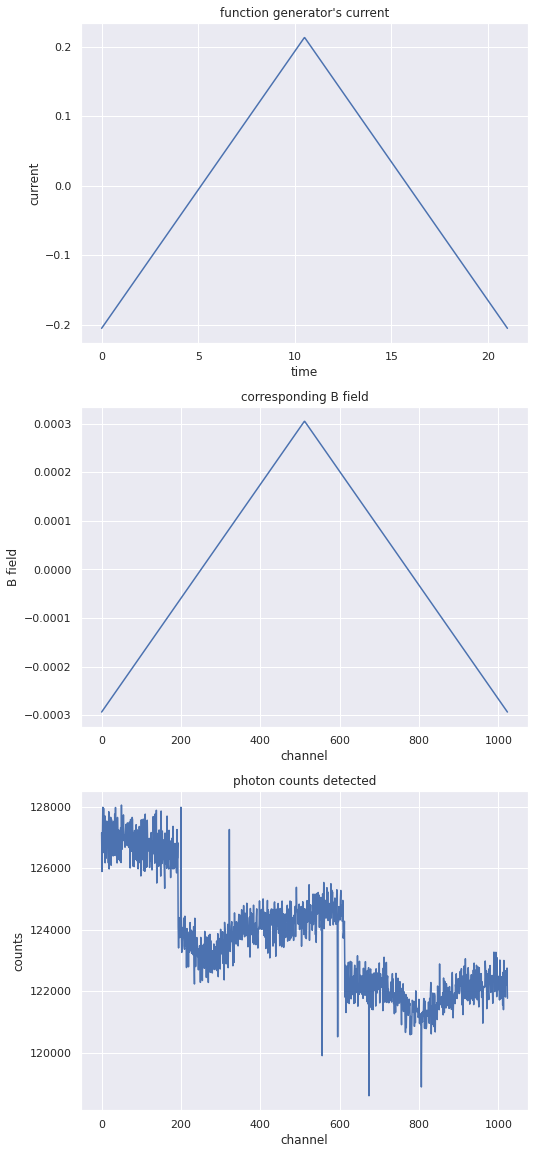

In [97]:
data_file = './Data/hanle_90'
period = 21.0084
channel_num= 1024

current_min = np.array([-0.19819,-0.20710,-0.20710,-0.20710,-0.20694])
current_max = np.array([0.21369,0.21367,0.21396,0.21316,0.21316])

current_min = unc.ufloat(current_min.mean(),current_min.std())
current_max = unc.ufloat(current_max.mean(),current_max.std())

column_name=['channel', 'count']
data = processing(data_file,
                    period = period,
                    current_min = current_min,
                    current_max = current_max,
                    channel_num= channel_num)

myplot(data)